# Gaussian Mixture Model for Wind Data

I illustrate how a mixed gaussian model can be an effective way to model the distribution of wind speed and direction data compared to existing approaches. By considering an example of DNV's publicly available Nyserda buoy off the coast of New Jersey, I'll use the scikit-learn library to fit the model and plot the fit with the data.

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm, weibull_min
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture

The data in this example comes from a buoy-mounted lidar off the coast of new Jersey. The data can be found at https://oswbuoysny.resourcepanorama.dnv.com/download/f67d14ad-07ab-4652-16d2-08d71f257da1. 

<table><tr>
<td> <img src="images/nyserda_buoys.PNG" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/buoy_image.PNG" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

In [2]:
# read data

df_raw = pd.read_csv('E05_Hudson_North_10_min_avg_20190812_20210919.csv', index_col='timestamp', low_memory=False)
df_raw.index = pd.to_datetime(df_raw.index)

In [3]:
# extract wind data at 198m

df = pd.DataFrame()
raw_colnames = [' lidar_lidar198m_Z10_HorizWS', ' lidar_lidar198m_WD_alg_03', ' lidar_lidar198m_Z10_Packets']
new_colnames = ['speed', 'direction', 'packets']
for name, col in zip(new_colnames, raw_colnames):
    df[name] = pd.to_numeric(df_raw[col], errors='coerce')

In [4]:
# clean data

# only include time-steps with at least 30 packets corresponding to the 10minute time periods with 75% data recovery rate
df_cln = df.loc[df.packets > 30].dropna()
df_cln.describe()

,speed,direction,packets
count,81025.000000,81025.000000,81025.000000
mean,10.077765,214.013340,36.325159
std,5.099659,103.198823,1.873905
min,0.509900,0.011600,31.000000
25%,6.201600,125.655800,36.000000
50%,9.365700,240.037000,37.000000
75%,13.296800,298.954200,38.000000
max,33.094800,359.997000,40.000000


One of the most common ways to represent the joint distribution of wind speed and direction is to split the data into direction sectors and fit a Weibull distribution to each one.

Let $M$ be the number of direction sectors. Under this model, the probability of wind speed $r$ in a given wind sector $m \in (0, 1, 2, ..., M-1)$ is given by a weibull distribution with scale parameter $\lambda_m$ and shape parameter $k_m$, and the probability of sector $m$ is $p(m) = \rho_m$ where $\sum_{m=0}^{M-1} \rho_m = 1$.

Below, I set each $\rho_m$ to the count of direction data in sector $m$ divided by the total number of data points. I estimate parameters $\lambda_m$ and $k_m$ by using `scipy.stats.weibull_min.fit`.



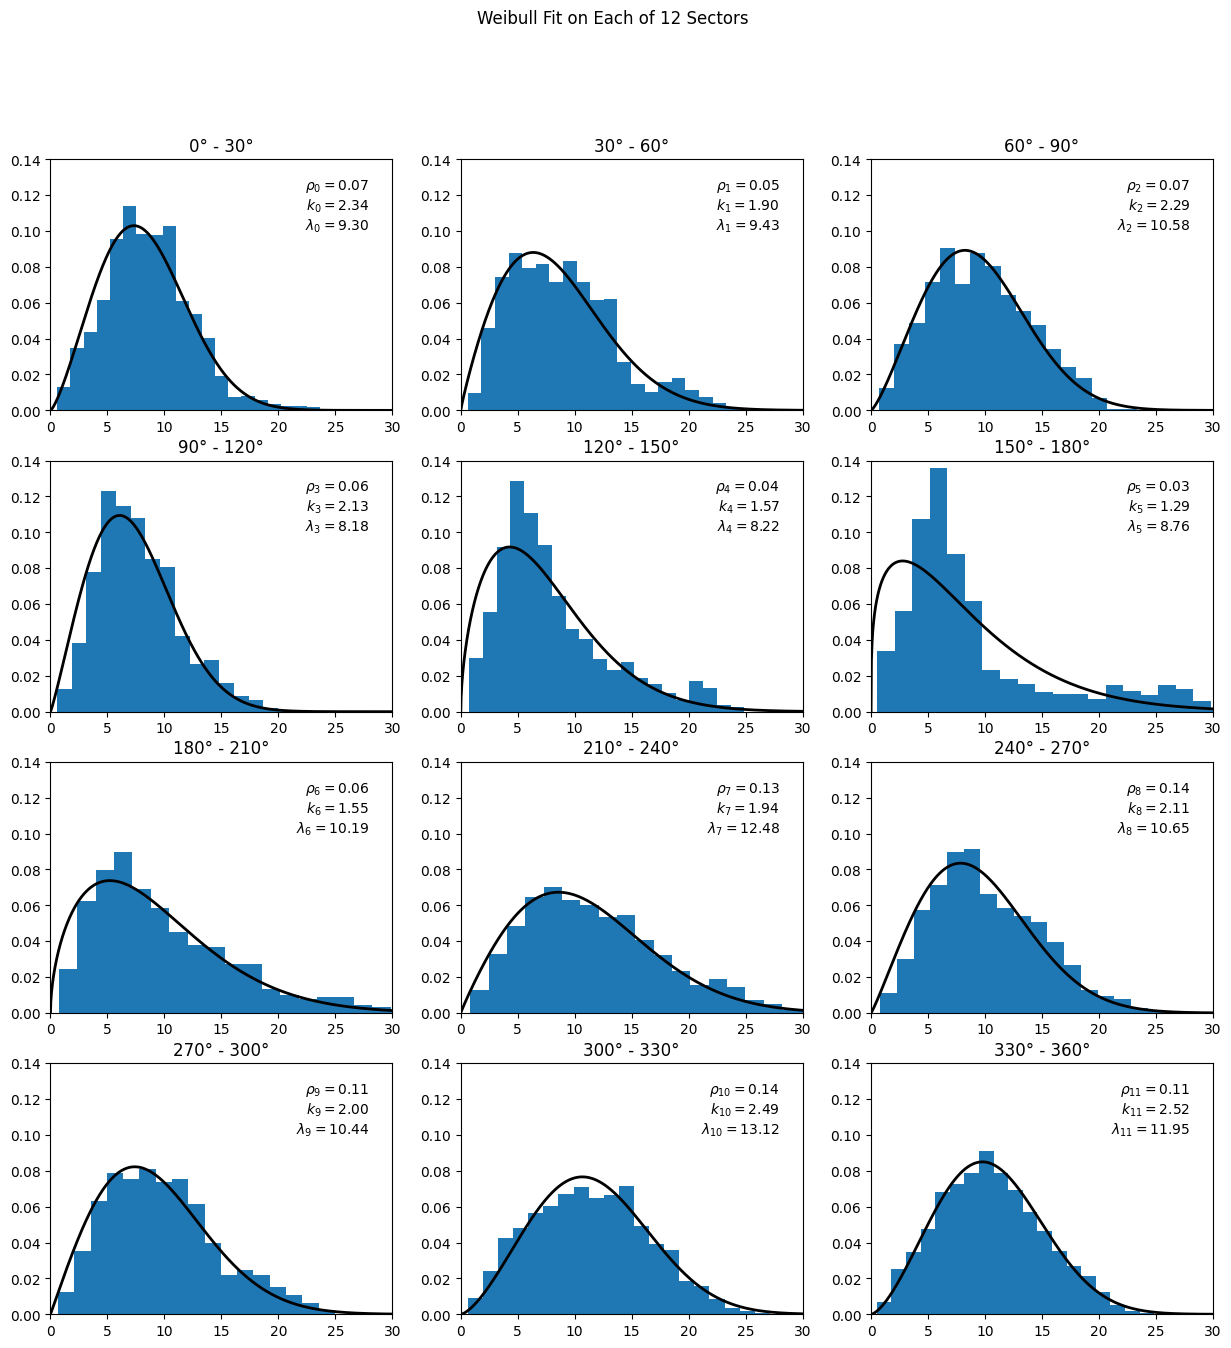

In [5]:
M = 12 # number of direction sectors
SECTOR_WIDTH = 360/M # size in degrees of each direction bin

# initalize lists of Weibull parameters
rho = []
k_shape = []
lambda_scale = []

# plot settings
max_spd = 30
max_freq = 0.14
fig, axs = plt.subplots(M//3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

# iterate through each direction sector, creating fit and plotting results
for sector in range(M):
    # axis settings
    ax = axs[sector//3, sector % 3]
    ax.set_xlim([0, max_spd])
    ax.set_ylim([0, max_freq])

    # fit model
    spd = df_cln.loc[df_cln.direction//SECTOR_WIDTH == sector, 'speed'] # get speed values from specified direction sector

    # calculate rho
    rh = spd.shape[0]/df_cln.shape[0] # frequency of data in direction bin
    rho.append(rh)

    # fit weibull
    k, _, l = weibull_min.fit(spd) # derive shape and scale parameters
    k_shape.append(k)
    lambda_scale.append(l)

    # plot histogram
    ax.hist(spd, bins=20, density=True)

    # plot Weibull pdf
    rs = np.linspace(0, max_spd, 1000)
    ax.plot(rs, weibull_min.pdf(rs, k, scale=l), color='black', linewidth=2)

    # plot text
    ax.set_title(f'{sector*SECTOR_WIDTH:.0f}° - {(sector+1)*SECTOR_WIDTH:.0f}°')
    ax.text(28, 0.13,  f'$\\rho_{{{sector}}}=${rh:.2f}\n$k_{{{sector}}}=${k:.2f}\n$\\lambda_{{{sector}}}=${l:.2f}', fontsize=10, horizontalalignment='right', verticalalignment='top')

rho = np.array(rho)
k_shape = np.array(k_shape)
lambda_scale = np.array(lambda_scale)

fig.suptitle('Weibull Fit on Each of 12 Sectors')
plt.show()

This plot illustrates how the sector-wise Weibull model works. A probability $\rho_m$ is assigned to each direction bin, and wind speeds within that direction bin are governed by the two parameters $\lambda_m$ and $k_m$. Weibulls generally model wind speed well; however, with only two parameters, they can fail to capture more complex wind distributions like the one in the 150° - 180° sector. The weibul provides a realistic shape, but suffers from under-fitting in some circumstances.

In contrast, the wind direction component of the model has substantial flexbility with a parameter for each direction sector, but the resulting shape is unrealistic. The pdf is a step function with the probability of sector $m$ governed by $\rho_m$.

Below is a visualization using a conventional histogram and a polar plot.

In [6]:
# define pdf function for M sector approximation
def deg_sector_pdf(deg, rho):
    return np.array(rho)[(deg//SECTOR_WIDTH).astype(int)]/SECTOR_WIDTH

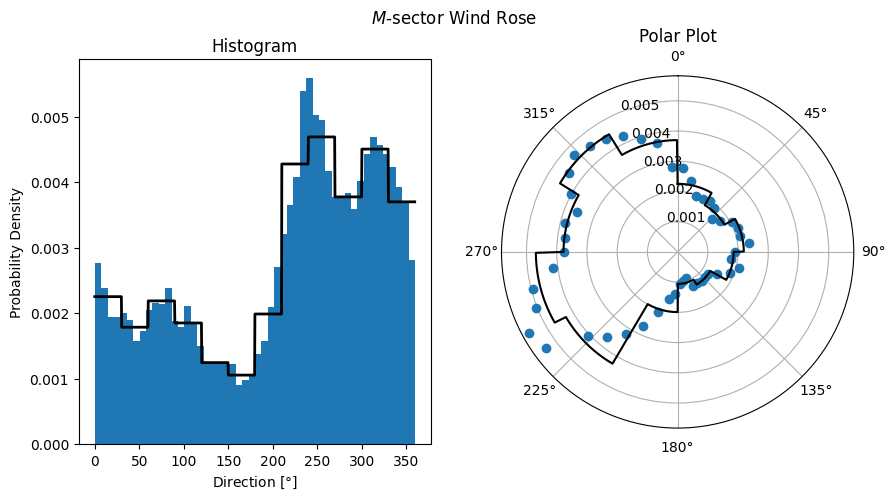

In [7]:
def direction_plots():
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)  # Normal subplot
    ax2 = fig.add_subplot(1, 2, 2, polar=True)  # Polar subplot
    
    nbins = 50
    xmin = 0
    xmax = 360
    bin_width = (xmax - xmin)/nbins
    # Plot the histogram.
    vals, bins, _ = ax1.hist(df_cln['direction'], bins=nbins, density=True) # save the valus of histogram for use in the polar plot
     
    # Plot the PDF.
    degs = np.linspace(xmin, xmax, 1000, endpoint=False)
    # radians = degs*np.pi/180
    # deg_pdf_vals = mixture_pdf(radians, thetak_pdf, estimator)*np.pi/180
    deg_pdf_vals = deg_sector_pdf(degs, rho)
    ax1.plot(degs, deg_pdf_vals, 'k', linewidth=2)
    ax1.set_title('Histogram')
    ax1.set_ylabel('Probability Density')
    ax1.set_xlabel('Direction [$\degree$]')
    
    # plt.title('Sector-wise Binning Estimation')
     
    bin_midpoints = bins[:-1] + bin_width/2
    # bin_midpoints_radians = bin_midpoints/180*np.pi
    # r = np.arange(0, 2, 0.01)
    theta_hist = bin_midpoints/180*np.pi
    # theta_hist = np.append(theta_hist, theta_hist[0])
    rs =  vals
    # rs = np.append(rs, rs[0])
    
    # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax2.plot(theta_hist, rs, 'o')
    
    radians = degs*np.pi/180
    
    ax2.set_title('Polar Plot')
    ax2.plot(list(radians) + [radians[0]], list(deg_pdf_vals) + [deg_pdf_vals[0]], color='black')
    ax2.set_theta_direction(-1)
    ax2.set_theta_offset(np.pi / 2.0)
    ax2.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    ax2.grid(True)
    return(ax1, ax2)

# plt.legend(['Measured', 'Modeled'])
direction_plots()

# ax.set_title("Gaussian Mixture Direction Distribution", va='bottom')
plt.suptitle('$M$-sector Wind Rose')
plt.show()

The Weibull curves and wind rose can be combined to make a joint distribution 
$p(r, m | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda})$ where $\boldsymbol{\rho} = (\rho_1, \rho_2, ..., \rho_M)$ is the vector of wind sector probabilities and $\textbf{k} = (k_1, k_2, ..., k_M)$, $\boldsymbol{\lambda} = (\lambda_1, \lambda_2, ..., \lambda_M)$ are the weibull parameters for each wind sector. Using the product rule of probabilities,

$$p(r, m | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda}) = p(m | \boldsymbol{\rho}) p(r,| m, \textbf{k}, \boldsymbol{\lambda}) = \rho_m W(r | k_m, \lambda_k)$$

where  $W(\cdot, k, \lambda)$ is the weibull probability density function with shape $k$ and scale $\lambda$. Then using the sum rule to marginalize out the wind sectors, you get an expression for the overall speed:
$$ p(r | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda}) = \sum_{m=0}^{M-1} p(r , m| \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda}) = \sum_{m=0}^{M-1} \rho_m W(r | k_m, \lambda_k). $$

The result is a mixture of weibulls where $\boldsymbol{\rho}$ determines the weight of each Weibull component. The resulting distribution is plotted below against the overall histogram.

In [8]:
def weibull_mixture_pdf(r, rho, k_shape, lambda_scale):
    p = 0
    for rh, k, l in zip(rho, k_shape, lambda_scale):
        p+= rh*weibull_min.pdf(r/l, k)/l
    return p

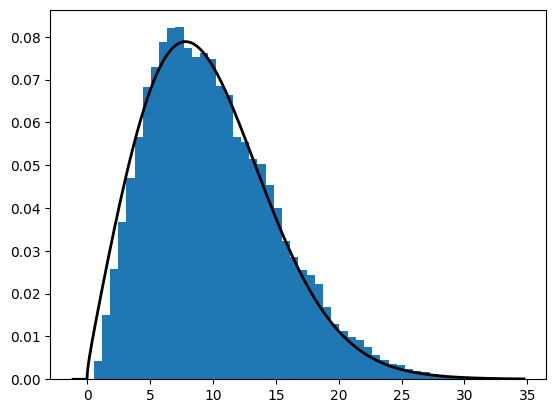

In [9]:
plt.hist(df_cln.speed, bins=50, density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
rs = np.linspace(xmin, xmax, 1000)
 
plt.plot(rs, weibull_mixture_pdf(rs, rho, k_shape, lambda_scale), color='black', linewidth=2)

plt.show()

## Mixed-Gaussian Model

Mixed gaussian models are a generalized form of $k$-means clustering and falls under a broad category of expectation-maximization algorithms. They all work by introducing a latent, unobserved variable. The process alternates between estimating the latent variable and the model parameters until a local minimum of the loss function is found. In this case, the latent variable will be assigning data points to one of $K$ classes each corresponding to a gaussian distribution.


The Weibull per sector model worked by assigning each data point to one of $M$ wind sectors based on it's direction, and then using a corresponding Weibull distribution for that wind sector. The mixed-gaussian works in a similar way; however, rather than explicitly determining the class of a datapoint from a pre-defined process, the mixed-gaussian model implicitly infers the class that maximized the likelihood of the data.

Similar to the $\boldsymbol{\rho}$ sector probabilities in the Weibull-by-sector model, the Mixed-gaussian has mixing coefficients $\boldsymbol{\pi} = (\pi_1, \pi_2, ..., \pi_K)$ where $\sum_{z=0}^{K-1} \pi_z = 1$ that define the probability of latent variable $z \in (0, 1, ..., K-1)$. Specifically, 

$$p(z | \boldsymbol{\pi}) = \pi_z$$

In the same way that the Weibull by sector model represented wind speed as a Weibull conditioned on the wind sector $m$, the mixed gaussian model represents wind speed and direction conditioned on the latent variable $z \in (0, 1, ..., K-1)$. That is, 

$$ p(\textbf{v} | z, \boldsymbol{\mu}, \boldsymbol{\sigma}) = N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I)$$

where $\textbf{v} = (x, y)$ is the wind velocity vector broken into east and north components so that $x = r \cos{\theta}$ and $y = r\sin\theta$. The model parameters are $K$ dual component location parameters $\boldsymbol{\mu} = (\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, ..., \boldsymbol{\mu}_K)$ and $K$ scale parameters $\boldsymbol{\sigma} = (\sigma_1, \sigma_2, ..., \sigma_K)$ for the bivariate isotropic normal distribution $N(\cdot, \boldsymbol{\mu}, \sigma^2 I)$ 

Then repeating the product and sum rule as we did before we get the marginalized likelihood of the wind velocity vector


$$ p(\textbf{v} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\sigma}) = \sum_{z = 0}^{K-1} \pi_z N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I)$$

which takes the same form as the Weibull by sector model.

In fact, the two models have almost the exact same graphical representation. The primary difference is that $z$ is unobserved while $m$ is known in advance.

<div>
<img src="images/graphical_model_comparison.png" width="500"/>
</div>

## Intuition behind Mixed-gaussian model

The underlying assumption of the Weibull by sector model is that wind speed is the sum of unique wind distributions under different wind direction conditions. We saw this with
$$ p(r | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda}) = \sum_{m=0}^{M-1} \rho_m W(r | k_m, \lambda_k). $$

A strength in this model is that it captures the different profiles of wind speed that are explained by the wind sector it comes from. However, wind speed is not only characterized by wind direction. There are a number of other important factors that contribute to the wind distribution including turbulence intensity, stability conditions, diurnal, and seasonal factors. For example, if a wind distribution has a very different weibull in the day than at night, one could imagine a wind sector containing two very different distributions resulting in a bimodal distribution that can't be estimated with a Weibull.

The strength by assigning latent variable categories is that they may correspond to different wind sectors, but they can also correlate with diurnal and seasonal factors or even unknown factors. It's reasonable to believe that under specific known or unknown conditions, wind velocities are characterized by a simple gaussian and that the aggregate wind distribution is a sum result of these conditions.

$$ p(\textbf{v} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\sigma}) = \sum_{z = 0}^{K-1} \pi_z N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I)$$



## Implementing Mixed-gaussian

I use `sklearn.mixture.GaussianMixture` to train the model with $K=9$ components.

In [10]:
# convert speed and direction into corresponding east and north components
vel_east = (df_cln.speed*np.sin(df_cln.direction/180*np.pi)).to_numpy()
vel_north = (df_cln.speed*np.cos(df_cln.direction/180*np.pi)).to_numpy()

In [11]:
# train gaussian mixture
X_train = np.vstack([vel_east, vel_north]).T

n_classes = 9

estimator = GaussianMixture(n_components=n_classes, covariance_type="spherical", max_iter=100, random_state=0)
estimator.fit(X_train)


GaussianMixture(covariance_type='spherical', n_components=9, random_state=0)

## Joint Density Plots

To illustrate the results of the training, the plots below show a scatter plot of measured wind vectors overlayed with the mixed gaussian distribution.

In [12]:
# plotting helper function
def ax_setup(ax):
    ax.set_aspect('equal')
    ax.axhline(0, color='black', linewidth =0.5, alpha=0.5)
    ax.axvline(0, color='black', linewidth = 0.5, alpha=0.5)

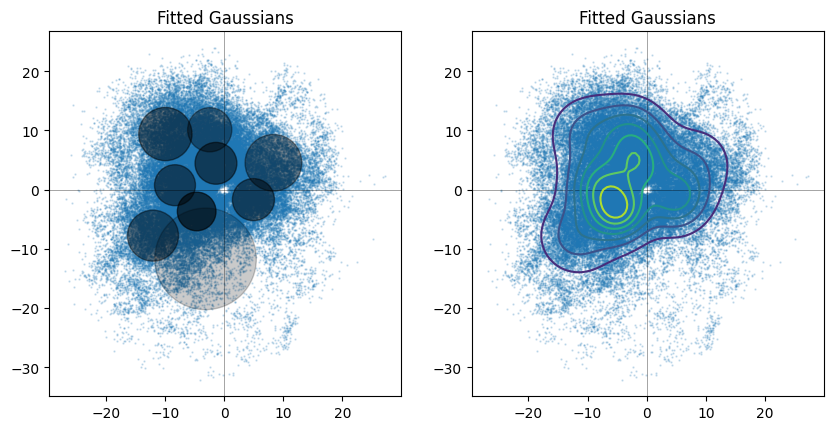

In [13]:
# plot circles

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axs
ax_setup(ax1)
ax_setup(ax2)

ax1.scatter(vel_east, vel_north, alpha=0.2, s=0.5)
ax1.set_title('Fitted Gaussians')

colors = ["navy", "turquoise", "darkorange", "red", "yellow", "green", "purple", "tan", "white"]

circles = []
names = []
for idx in range(n_classes):
    mu = estimator.means_[idx]
    sigma = np.sqrt(estimator.covariances_[idx])
    circle = mpl.patches.Circle(xy=mu, radius=sigma, color="black", alpha=estimator.weights_[idx]*4)
    ax1.add_artist(circle)
    circles.append(circle)
    names.append(idx)
    
# ax1.legend(circles, names)

ax2.scatter(vel_east, vel_north, alpha=0.2, s=0.5)
plt.title('Fitted Gaussians')

xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
x = np.linspace(xmin, xmax, num=100)
y = np.linspace(ymin, ymax, num=100)
X, Y = np.meshgrid(x,y)

pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = np.exp(estimator.score(np.array([[X[i,j], Y[i,j]]])))

ax2.contour(X,Y,pdf)

plt.show()

The left plot represents each gaussian component $k$ as a circle with center $\boldsymbol{\mu}_k$ and radius $\sigma_k$ where the shading is proportional to $\pi_k$. The right plot shows a contour plot of the resulting distribution.

## Metrics for Model Selection

There are a number of goodness-of-fit metrics one could use to quantitatively compare the Gaussian mixture model and the Weibull by sector model. For example, one could minimize the Akaike information criterion 
$$\text{AIC} = 2k - 2\ln(\hat{L}) $$ 
or maximize the Bayesian information criterion
$$ \text{BIC} = k \ln{n} + \ln(\hat{L}) $$
where $k$ is the number of parameters in the model, $N$ is the number of observations, and $\hat{L}$ is the maxized value of the likelihood function.

The Weibull by sector model has $M$ sectors, each with their own Weibull distribution with two parameters $k_m$ and $\lambda_k$. Additionally there are $M$ wind rose coefficients $\boldsymbol{\rho}$, but because of the $\sum_{m=1}^{M} \rho_m = 1$ constraint, this constitutes only $M-1$ degrees of freedom. So, in total, the Weibull by sector model has $3M - 1$ parameters. 

The Gaussian mixture model has $K$ components, each with an isotropic bivariate normal distribution with the location parameter $\boldsymbol{\mu}_k$ which contains an $x$ and $y$ component and the scale parameter $\sigma_k$. Finally, adding the $K-1$ mixing coefficients, the total number of parameters for the Gaussian mixture is $4K - 1$

Since $M=12$ and $K=9$, both models have the 35 parameters. So, under the AIC and BIC, the model with the better fit is the one that maximizes $\ln(\hat{L})$.

## Calculate Log Likelihood

The likelihood function $L$ calculates the conditional probability of some observed data $X = (x_1, x_2, ..., x_N)$ given the model parameters $\boldsymbol{\theta}$ is $p(X | \boldsymbol{\theta})$. If the data is independent and identically distributed then the log likelihood is 
$$\ln(L) = \ln\left(\prod_{i=1}^N p(x_i | \boldsymbol{\theta})\right) = \sum_{i=1}^N \ln(p(x_i | \boldsymbol{\theta})).$$
Let $\hat{\boldsymbol{\theta}}$ be the parameters that maximizes the likelihood so that 
$$\ln(\hat{L})  = \sum_{i=1}^N \ln(p(x_i | \boldsymbol{\hat{\theta}})).$$

Scipy's `GaussianMixture.score_samples` method calculates the log likelihood subject to the optimized model parameters. So, it's very straightforward to find a value for $\hat{L}$

In [14]:
# calculate the log likelihood of the observed data for the Gaussian mixture model
estimator.score_samples(X_train).sum()

-553471.1428415166

The Weibull by sector model requires a little more work. If assuming independent, indentically distributed data, then 

$$\ln(\hat{L})  = \sum_{n=1}^N \ln(p(\textbf{v}_n | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda}))$$

$$ = \sum_{n=1}^N \ln\left(p(r_n, \theta_n | \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda})\frac{1}{r}\right)$$

$$ = \sum_{n=1}^N \ln(p(\theta_n | \boldsymbol{\rho})) + \ln(p(r_n | \theta_n, \boldsymbol{\rho}, \textbf{k}, \boldsymbol{\lambda})) - \ln(r)$$

where the $\frac{1}{r}$ term is the Jacobian determinant involved in transforming the data from cartesian to polar coordinates. The resulting formula breaks the likelihood function into functions that are already defined. The next cells calculates the result.

In [15]:
theta = df_cln.direction.to_numpy()*np.pi/180
N = df_cln.shape[0]
R = df_cln.speed.to_numpy()
sector_width_rad = 2*np.pi/M
s_theta = (theta//sector_width_rad).astype(int)

theta_term = (deg_sector_pdf(df_cln.direction.to_numpy(), rho)*180/np.pi).sum()
spd_term = df_cln.speed.to_numpy()

In [16]:
np.log(rho[s_theta]/sector_width_rad).sum() + weibull_min.logpdf(R, k_shape[s_theta], scale=lambda_scale[s_theta]).sum() - np.log(R).sum()

-555192.0143633565

Since the first log likelihood is higher, the mixed Gaussian is a better fit to the data.

## Speed Distribution

To derive an expression for the distribution of the wind speed according to the mixed gaussian, you must marginalize out the direction component of the full distribution.

$$ p(r | \boldsymbol{\pi}, \boldsymbol{\mu}_z, \boldsymbol{\sigma}_z) = \int_0^{2\pi} p(\textbf{v} | \boldsymbol{\pi}, \boldsymbol{\mu}_z, \boldsymbol{\sigma}_z) d\theta$$
$$   = \int_0^{2\pi} \sum_{z = 0}^{K-1} \pi_z N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I) d\theta$$

$$ =  \sum_{z = 0}^{K-1} \left(\pi_z  \int_0^{2\pi} N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I) d\theta \right)$$

$$  =  \sum_{z = 0}^{K-1} \pi_z \frac{r}{\sigma_z^2} \exp \left( - \frac{r^2 + \lVert\boldsymbol{\mu}_z\rVert^2}{2\sigma_z^2}\right) I_0 \left(\frac{r \lVert\boldsymbol{\mu_z}\rVert}{\sigma_z^2} \right) $$

The last step comes from Cooper and Farid's "A Toolbox for the Radial and Angular Marginalization of
Bivariate Normal Distributions".

Below, I plot the resulting distribution as it compares to the Weibull by sector model.

In [17]:
def rk_pdf(r, mu, sigma2):
    # marginalized likelihood for the radius for one of the gaussians
    a = np.linalg.norm(mu)
    ps = r/sigma2*np.exp(-(r**2 + a**2)/2/sigma2)*np.i0(r*a/sigma2)
    return np.maximum(ps, 0)

In [18]:
def mixture_pdf(x, fxn, estimator):
    p = 0
    for k in range(len(estimator.means_)):
        p += estimator.weights_[k]*fxn(x, estimator.means_[k], estimator.covariances_[k])
    return p

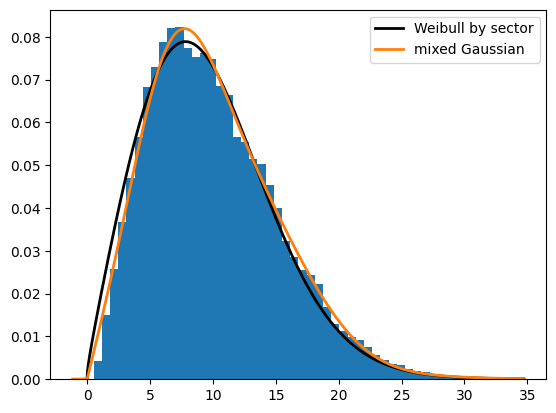

In [19]:

# Plot the histogram.
plt.hist(df_cln.speed, bins=50, density=True)
 
# Plot the PDF.
xmin, xmax = plt.xlim()
rs = np.linspace(xmin, xmax, 1000)

plt.plot(rs, weibull_mixture_pdf(rs, rho, k_shape, lambda_scale), color='black', linewidth=2)
plt.plot(rs, mixture_pdf(rs, rk_pdf, estimator), linewidth=2)

plt.legend(['Weibull by sector', 'mixed Gaussian'])
 
plt.show()

## Direction Distribution

For the direction distribution, you must marginalize out the direction component of the full distribution.

$$ p(\theta | \boldsymbol{\pi}, \boldsymbol{\mu}_z, \boldsymbol{\sigma}_z) = \int_0^{\infty} p(\textbf{v} | \boldsymbol{\pi}, \boldsymbol{\mu}_z, \boldsymbol{\sigma}_z) dr$$
$$   = \int_0^{\infty} \sum_{z = 0}^{K-1} \pi_z N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I) dr$$

$$ =  \sum_{z = 0}^{K-1} \left(\pi_z  \int_0^{\infty} N(\textbf{v} | \boldsymbol{\mu}_z , \sigma_z^2 I) dr \right)$$

$$  =  \sum_{z = 0}^{K-1} \pi_z \frac{1}{\sqrt{2\pi}} \phi(\lVert \boldsymbol{\mu_z} \rVert) \left( 1 + \frac{b \Phi (b)}{\phi(b)} \right) $$

where $b = \frac{1}{\sigma_z} (\mu_x \cos(\theta) + \mu_y \sin(\theta))$. $\phi$ is the probability density function of a univariate normal distribution with mean 0 and variance 1 and $\Phi$ is the cumulative distribution function for said normal distribution.

The last step comes from Cooper and Farid's "A Toolbox for the Radial and Angular Marginalization of
Bivariate Normal Distributions".

Below, I plot the resulting distribution as it compares to the Weibull by sector model.

In [20]:
def thetak_pdf(theta, mu, sigma2):
    # marginal pdf for degree oriented from the North going clockwise for a single gaussian
    sigma = np.sqrt(sigma2)
    a = np.linalg.norm(mu)/sigma
    b = (mu[0]*np.sin(theta) + mu[1]*np.cos(theta))/sigma
    return norm.pdf(a)/np.sqrt(2*np.pi)*(1+b*norm.cdf(b)/norm.pdf(b))

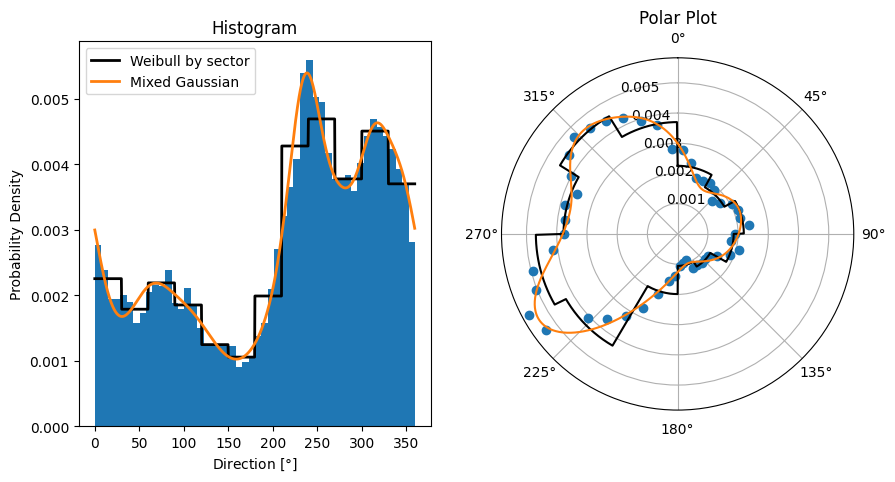

In [21]:
ax1, ax2 = direction_plots()

# Plot the PDF.
degs = np.linspace(0, 360, 1000, endpoint=False)
# radians = degs*np.pi/180
# deg_pdf_vals = mixture_pdf(radians, thetak_pdf, estimator)*np.pi/180
deg_pdf_vals = mixture_pdf(degs*np.pi/180, thetak_pdf, estimator)*np.pi/180
ax1.plot(degs, deg_pdf_vals, linewidth=2)
ax1.legend(['Weibull by sector', 'Mixed Gaussian'])

ax2.plot(degs*np.pi/180, deg_pdf_vals)


plt.show()

## Conditional Distribution

The last plot comparison will show the wind distribution of the two models in each wind sector. The correct way to get a wind speed distribution for a particular sector would be to marginalize $\theta$ over a single sector width, but the resulting integral does not have a closed form. Instead, I'll estimate the mixed Gaussian wind speed distribution by finding the distribution of wind speed conditional on the sector midpoint. Note that

$$ p(r | \theta) = \frac{p(r, \theta)}{p(\theta)}. $$

The conditional distribution is the quotient of the joint distribution and the marginal distribution which are shown in previous cells.

In [22]:
def joint_pdf(r, theta, estimator):
    x = r*np.sin(theta)
    y = r*np.cos(theta)
    xy = np.vstack([x, y]).T
    return np.maximum(r*np.exp(estimator.score_samples(xy)), 0)

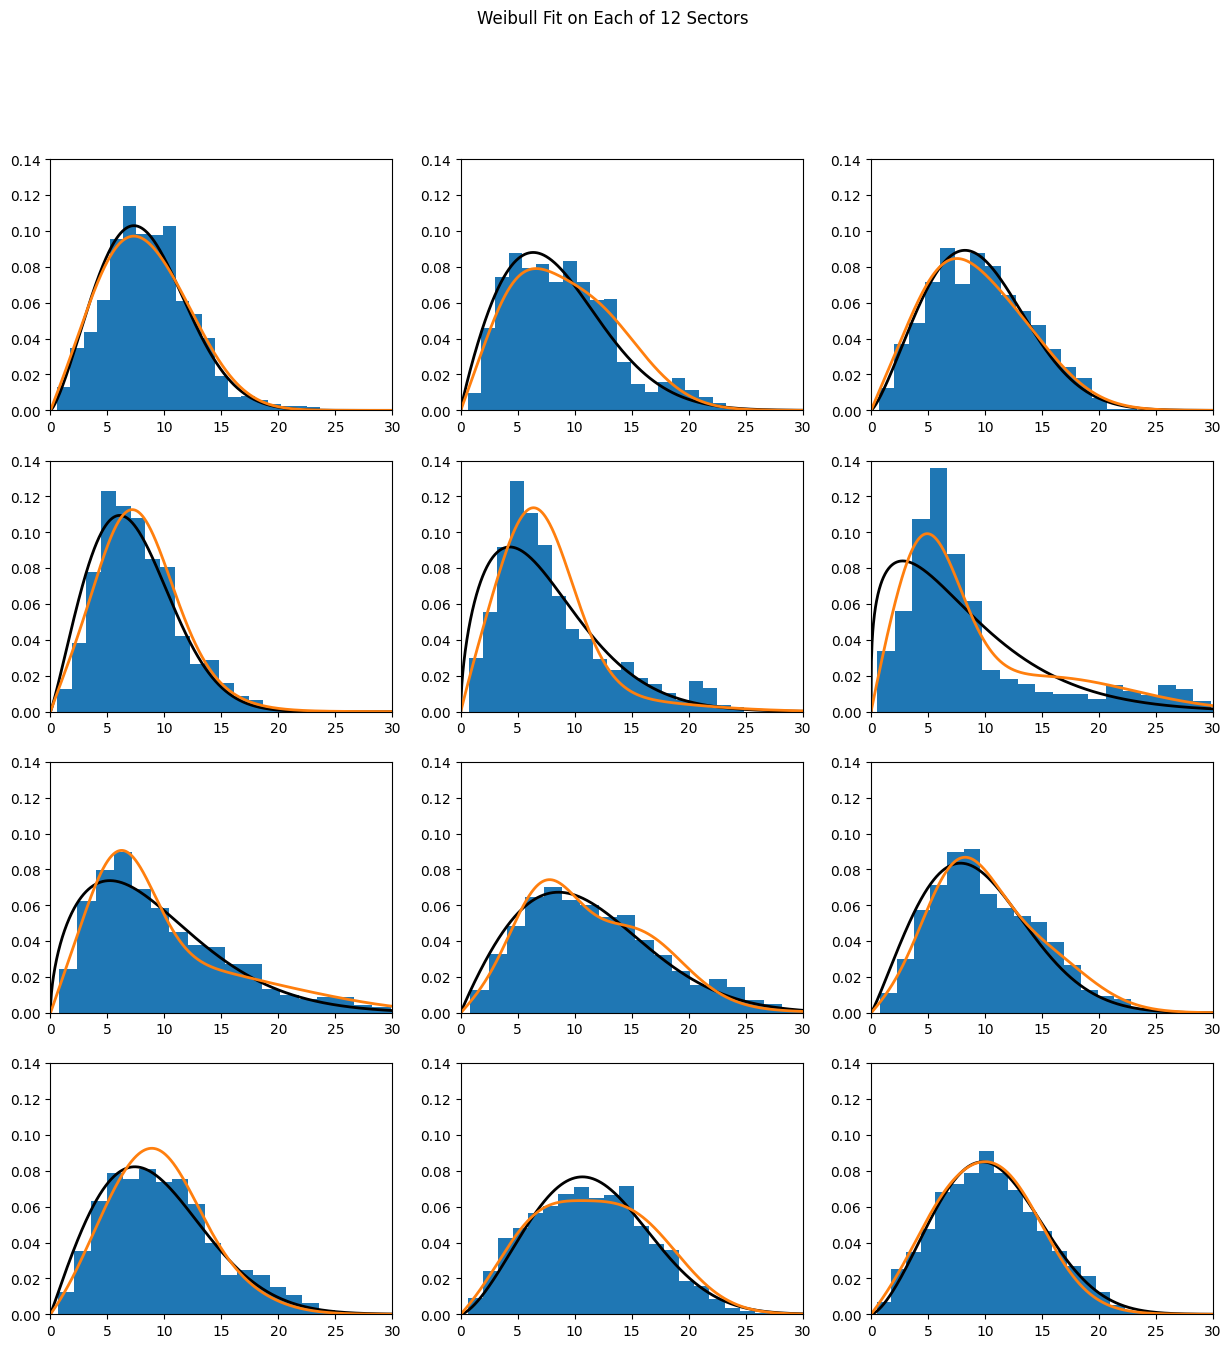

In [23]:
M = 12 # number of direction sectors
SECTOR_WIDTH = 360/M # size in degrees of each direction bin

# plot settings
max_spd = 30
max_freq = 0.14
fig, axs = plt.subplots(M//3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)

# iterate through each direction sector, creating fit and plotting results
for sector in range(M):
    # axis settings
    ax = axs[sector//3, sector % 3]
    ax.set_xlim([0, max_spd])
    ax.set_ylim([0, max_freq])

    # fit model
    spd = df_cln.loc[df_cln.direction//SECTOR_WIDTH == sector, 'speed'] # get speed values from specified direction sector

    # fit weibull
    k = k_shape[sector]
    l = lambda_scale[sector]
    
    # plot histogram
    ax.hist(spd, bins=20, density=True)

    # plot Weibull pdf
    theta = SECTOR_WIDTH*(sector + 0.5)*np.pi/180
    rs = np.linspace(0, max_spd, 1000)
    ax.plot(rs, weibull_min.pdf(rs, k, scale=l), color='black', linewidth=2)

    # plot
    ax.plot(rs, joint_pdf(rs, theta, estimator)/mixture_pdf(theta, thetak_pdf, estimator), linewidth=2)

fig.suptitle('Weibull Fit on Each of 12 Sectors')
plt.show()